## About the Data - Diabetes Dataset from 130 US hospitals, 1999-2008
Data From: UCI Machine Learning Repository, https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008#<br>

Abstract: This data has been prepared to analyze factors related to readmission as well as other outcomes pertaining to patients with diabetes.<br>

Source: The data are submitted on behalf of the Center for Clinical and Translational Research, Virginia Commonwealth University, a recipient of NIH CTSA grant UL1 TR00058 and a recipient of the CERNER data. John Clore (jclore '@' vcu.edu), Krzysztof J. Cios (kcios '@' vcu.edu), Jon DeShazo (jpdeshazo '@' vcu.edu), and Beata Strack (strackb '@' vcu.edu). This data is a de-identified abstract of the Health Facts database (Cerner Corporation, Kansas City, MO).<br>

Data Set Information: The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.<br>
(1) It is an inpatient encounter (a hospital admission).<br>
(2) It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.<br>
(3) The length of stay was at least 1 day and at most 14 days.<br>
(4) Laboratory tests were performed during the encounter.<br>
(5) Medications were administered during the encounter.<br>
The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.<br>

In [1]:
### Import Dependencies
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Ignore Warnings
import warnings
warnings.simplefilter('ignore')

### Set Display Options
from IPython.display import Image
%matplotlib inline
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth",0)

## ML Modeling Outline

* Data Pre-Processing & Scaling
* Model Building, Round 1 (Base Model, all features included)
* Feature Selection
* Model Building, Round 2
* Hyperparameter Tuning of Best Model (From Round 2 Models, Select the Best & Hypertune It)

## Data Dictionary

In [2]:
data_dictionary_clean = pd.read_csv("Resources/data_dictionary_clean.csv")
data_dictionary_clean.head()

,Feature,Data_Label,Data_Description,Data_Type
0,y,readmit,Recoded - Readmit (yes = 1/no),dichotomous/binary
1,y,readmit_<30_days,Recoded - less than 30 days (yes=1/no),dichotomous/binary
2,x,race_?,Race/Ethnicity,dichotomous/binary
3,x,race_AfricanAmerican,Race/Ethnicity,dichotomous/binary
4,x,race_Asian,Race/Ethnicity,dichotomous/binary


## Import Clean Data

In [3]:
### Read Diabetes Data (ETL notebook csv export)
diabetes_race = pd.read_csv("Resources/diabetes_strat_race.csv")
diabetes_race.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,readmit,readmit_<30_days,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other/Unknown,gender_Female,gender_Male,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),weight_Unknown,weight_[0-25),weight_[100-125),weight_[125-150),weight_[175-200),weight_[50-75),weight_[75-100),admission_type_id_Elective,admission_type_id_Emergency,admission_type_id_NULL,admission_type_id_Newborn,admission_type_id_Not Available,admission_type_id_Not Mapped,admission_type_id_Trauma Center,admission_type_id_Urgent,discharge_disposition_id_Discharged to home,discharge_disposition_id_Discharged/transferred to ICF,discharge_disposition_id_Discharged/transferred to SNF,discharge_disposition_id_Discharged/transferred to a long term care hospital.,discharge_disposition_id_Discharged/transferred to another rehab fac including rehab units of a hospital.,discharge_disposition_id_Discharged/transferred to another short term hospital,discharge_disposition_id_Discharged/transferred to another type of inpatient care institution,discharge_disposition_id_Discharged/transferred to home under care of Home IV provider,discharge_disposition_id_Discharged/transferred to home with home health service,discharge_disposition_id_Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital,discharge_disposition_id_Discharged/transferred/referred to this institution for outpatient services,discharge_disposition_id_Expired,"discharge_disposition_id_Expired at home. Medicaid only, hospice.",discharge_disposition_id_Hospice / home,discharge_disposition_id_Hospice / medical facility,discharge_disposition_id_Left AMA,discharge_disposition_id_NULL,discharge_disposition_id_Neonate discharged to another hospital for neonatal aftercare,admission_source_id_Clinic Referral,admission_source_id_Emergency Room,admission_source_id_HMO Referral,admission_source_id_NULL,admission_source_id_Not Available,admission_source_id_Not Mapped,admission_source_id_Physician Referral,admission_source_id_Transfer from a Skilled Nursing Facility (SNF),admission_source_id_Transfer from a hospital,admission_source_id_Transfer from another health care facility,medical_specialty_?,medical_specialty_AllergyandImmunology,medical_specialty_Anesthesiology,medical_specialty_Cardiology,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_Gastroenterology,medical_specialty_Gynecology,medical_specialty_Hematology,medical_specialty_Hematology/Oncology,medical_specialty_Hospitalist,medical_specialty_InfectiousDiseases,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Neurology,medical_specialty_Obsterics&Gynecology-GynecologicOnco,medical_specialty_ObstetricsandGynecology,medical_specialty_Oncology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Osteopath,medical_specialty_Otolaryngology,medical_specialty_Pediatrics,medical_specialty_Pediatrics-CriticalCare,medical_specialty_Pediatrics-Endocrinology,medical_specialty_PhysicalMedicineandRehabilitation,medical_specialty_PhysicianNotFound,medical_specialty_Podiatry,medical_specialty_Psychiatry,medical_specialty_Psychology,medical_specialty_Pulmonology,medical_specialty_Radiologist,medical_specialty_Radiology,medical_specialty_Rheumatology,medical_specialty_Surgeon,medical_specialty_Surgery-Cardiovascular,medical_specialty_Surgery-Cardiovascular/Thoracic,medical_specialty_Surgery-Colon&Rectal,medical_specialty_Surgery-General,medical_specialty_Surgery-Neuro,medical_specialty_Surgery-Thoracic,medical_specialty_Surgery-Vascular,medical_specialty_SurgicalSpecialty,medical_specialty_Urology,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,diabetesMed_No,diabetesMed_Ye

## Data Pre-Processing
* Declare Independent & Dependent Variables
* Create Train-Test Splits of Our Variable Dataframes
* Scale & Transform Data for Modeling

In [4]:
### Declare Independent & Dependent Variables
X = diabetes_race.drop(["readmit"], axis=1)

# y-variable #1 - y_readmit (yes=1)
y = diabetes_race["readmit"].values.reshape(-1, 1)

print(X.shape, y.shape)

(3180, 120) (3180, 1)


In [5]:
### Create Train-Test Split of Our Variable Dataframes
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=999)
print(X_train.shape, y_train.shape)

(2385, 120) (2385, 1)


In [6]:
### Create MinMaxScaler
X_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

### Transform Train Data Using MinMaxScaler
X_train_scaler = X_scaler.transform(X_train)
y_train_scaler = y_scaler.transform(y_train)

### Transform Test Data Using MinMaxScaler
X_test_scaler = X_scaler.transform(X_test)
y_test_scaler = y_scaler.transform(y_test)

## Model # 1 - KNN Readmit Model 
* This model is based on the "readmit" variable and it indicates if the patient has been readmitted to the hospital.

In [7]:
### Create KNN Model & Fit It Using Training Data
train_scores = []
test_scores = []

for k in range(1, 20, 2): 
    
    ## Call the Classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    
    ## Train/Fit the Models
    knn.fit(X_train_scaler, y_train_scaler)
    
    ## Calculate Model Scores
    train_score = knn.score(X_train_scaler, y_train_scaler)
    test_score = knn.score(X_test_scaler, y_test_scaler)   
    
    ## Append Scores to Lists
    train_scores.append(train_score)
    test_scores.append(test_score)

    ## Print Train & Test Model Accuracy Scores for Each K (to 4 decimal places)
    print(f"k: {k}, Readmit Prediction Accuracy Train/Test Scores: {train_score:.4f}/{test_score:.4f}")

k: 1, Readmit Prediction Accuracy Train/Test Scores: 1.0000/0.6000
k: 3, Readmit Prediction Accuracy Train/Test Scores: 0.8092/0.6000
k: 5, Readmit Prediction Accuracy Train/Test Scores: 0.7589/0.6050
k: 7, Readmit Prediction Accuracy Train/Test Scores: 0.7208/0.6201
k: 9, Readmit Prediction Accuracy Train/Test Scores: 0.7090/0.6214
k: 11, Readmit Prediction Accuracy Train/Test Scores: 0.7048/0.6327
k: 13, Readmit Prediction Accuracy Train/Test Scores: 0.6901/0.6327
k: 15, Readmit Prediction Accuracy Train/Test Scores: 0.6881/0.6465
k: 17, Readmit Prediction Accuracy Train/Test Scores: 0.6881/0.6465
k: 19, Readmit Prediction Accuracy Train/Test Scores: 0.6839/0.6428


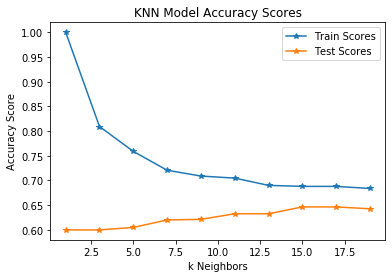

In [8]:
### Plot the Accuracy of the KNN Model
plt.plot(range(1, 20, 2), train_scores, marker="*", label="Train Scores")
plt.plot(range(1, 20, 2), test_scores, marker="*", label="Test Scores")
plt.title("KNN Model Accuracy Scores")
plt.xlabel("k Neighbors")
plt.ylabel("Accuracy Score")
plt.legend(loc=1)
plt.show()

In [9]:
### Iteration k=15 Provides the Best Accuracy
knn = KNeighborsClassifier(n_neighbors=15)
knn_model = knn.fit(X_train_scaler, y_train_scaler)
print('When k=15, test model accuracy is %.4f' % knn.score(X_test_scaler, y_test_scaler))

When k=15, test model accuracy is 0.6465


## Deep-Dive on KNN Model 

In [10]:
### Predictions Using KNN Model
knn_model_predict=knn_model.predict(X_test)

In [11]:
### Cross Validation of KNN Results
knn_model_cv_score = cross_val_score(knn_model, X, y, cv=10, scoring="roc_auc")

In [12]:
print("*** Confusion Matrix ***")
print(confusion_matrix(y_test, knn_model_predict))
print("\n")
print("*** Classification Report ***")
print(classification_report(y_test, knn_model_predict))
print("\n")
print("*** Mean AUC Score ***")
print("Mean AUC Score - Random Forest:", round(knn_model_cv_score.mean(),4))

*** Confusion Matrix ***
[[451   4]
 [335   5]]


*** Classification Report ***
              precision    recall  f1-score   support

           0       0.57      0.99      0.73       455
           1       0.56      0.01      0.03       340

    accuracy                           0.57       795
   macro avg       0.56      0.50      0.38       795
weighted avg       0.57      0.57      0.43       795



*** Mean AUC Score ***
Mean AUC Score - Random Forest: 0.5654


## Hyperparameter Tuning

In [13]:
### Create the GridSearch Object for Our Best Model (k=17)
grid_params = {"n_neighbors": [11, 13, 15, 17, 19],
              "weights": ["uniform", "distance"],
              "metric": ["euclidean", "manhattan"]}
grid_knn = GridSearchCV(KNeighborsClassifier(), grid_params, verbose=3)

In [14]:
### Train the Model with GridSearchCV Estimator (this tries each combination of parameters)
KNN_gridsearch = grid_knn.fit(X_train_scaler, y_train_scaler)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] metric=euclidean, n_neighbors=11, weights=uniform ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  metric=euclidean, n_neighbors=11, weights=uniform, score=0.619, total=   0.4s
[CV] metric=euclidean, n_neighbors=11, weights=uniform ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=11, weights=uniform, score=0.639, total=   0.5s
[CV] metric=euclidean, n_neighbors=11, weights=uniform ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=11, weights=uniform, score=0.617, total=   0.4s
[CV] metric=euclidean, n_neighbors=11, weights=distance ..............
[CV]  metric=euclidean, n_neighbors=11, weights=distance, score=0.621, total=   0.4s
[CV] metric=euclidean, n_neighbors=11, weights=distance ..............
[CV]  metric=euclidean, n_neighbors=11, weights=distance, score=0.626, total=   0.4s
[CV] metric=euclidean, n_neighbors=11, weights=distance ..............
[CV]  metric=euclidean, n_neighbors=11, weights=distance, score=0.627, total=   0.4s
[CV] metric=euclidean, n_neighbors=13, weights=uniform ...............
[CV]  metric=euclidean, n_neighbors=13, weights=uniform, score=0.602, total=   0.4s
[CV] metric=euclidean, n_neighbors=13, weights=uniform ...............
[CV]  metric=euclidean, n_neighbors=13, weights=uniform, score=0.629, total=   0.4s
[CV] metric=euclidean, n_neighbors=13, weights=uniform ...............
[CV]  metric=euclidean, n_neighbors=13, weights=uniform, score=0.63

[CV]  metric=manhattan, n_neighbors=19, weights=uniform, score=0.635, total=   0.4s
[CV] metric=manhattan, n_neighbors=19, weights=uniform ...............
[CV]  metric=manhattan, n_neighbors=19, weights=uniform, score=0.625, total=   0.4s
[CV] metric=manhattan, n_neighbors=19, weights=distance ..............
[CV]  metric=manhattan, n_neighbors=19, weights=distance, score=0.618, total=   0.4s
[CV] metric=manhattan, n_neighbors=19, weights=distance ..............
[CV]  metric=manhattan, n_neighbors=19, weights=distance, score=0.635, total=   0.4s
[CV] metric=manhattan, n_neighbors=19, weights=distance ..............
[CV]  metric=manhattan, n_neighbors=19, weights=distance, score=0.637, total=   0.4s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   25.7s finished


In [15]:
print("Best Model Score:")
print(KNN_gridsearch.best_score_)
print("\n")
print("Best Model Parameters:")
print(KNN_gridsearch.best_params_)

Best Model Score:
0.6381551362683439


Best Model Parameters:
{'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'uniform'}


## Apply Hypertuning to Our Best Model

In [16]:
knn_model_hypertuned = KNeighborsClassifier(metric="manhattan", n_neighbors=17, weights= "uniform")
knn_model_hypertuned.fit(X_train,y_train)
knn_model_hypertuned_predict = knn_model_hypertuned.predict(X_test)
knn_model_hypertuned_cv_score = cross_val_score(knn_model_hypertuned, X, y, cv=10, scoring='roc_auc')
print("When k=17, test model accuracy is %.4f" % knn_model_hypertuned.score(X_test_scaler, y_test_scaler))
print("\n")
print("*** Confusion Matrix ***")
print(confusion_matrix(y_test, knn_model_hypertuned_predict))
print("\n")
print("*** Classification Report ***")
print(classification_report(y_test, knn_model_hypertuned_predict))
print("\n")
print("*** Mean AUC Score ***")
print("Mean AUC Score - Random Forest: ", round(knn_model_hypertuned_cv_score.mean(),4))

When k=17, test model accuracy is 0.5723


*** Confusion Matrix ***
[[361  94]
 [221 119]]


*** Classification Report ***
              precision    recall  f1-score   support

           0       0.62      0.79      0.70       455
           1       0.56      0.35      0.43       340

    accuracy                           0.60       795
   macro avg       0.59      0.57      0.56       795
weighted avg       0.59      0.60      0.58       795



*** Mean AUC Score ***
Mean AUC Score - Random Forest:  0.589


## Plotting the AUROC Curve
* Area Under Receiver Operating Characteristic Curve (aka ROC-AUC)

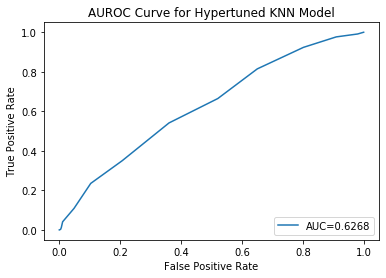

In [17]:
### Plotting the AUROC Curve
y_predict_probabilty = knn_model_hypertuned.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_predict_probabilty)
auc = round(metrics.roc_auc_score(y_test, y_predict_probabilty),4)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.title("AUROC Curve for Hypertuned KNN Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)
plt.show()